# Quantum Q‑Learning (Qiskit) — Q-function approximator as a QNN circuit
Your original notebook used a classical Q-table (and a PennyLane quantum section placeholder). Here we implement **Q-learning with a quantum neural network (QNN)** in **Qiskit Machine Learning**.

**Outputs you asked for:** the **QNN circuit** (feature map + ansatz) and training metrics.

> Note: Q-learning is still driven by a classical loop; the *function approximator* is a quantum circuit evaluated by Qiskit primitives (Sampler/Estimator) and can run on IBM Quantum backends.

In [1]:
%pip -q install "qiskit>=1.0" "qiskit-machine-learning>=0.8" "qiskit-ibm-runtime>=0.20" torch numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam

## 1) Toy environment (same scale as your notebook)
5 states, 2 actions. Transition and reward are synthetic but consistent. Replace this with your real environment later.

In [3]:
N_STATES = 5
N_ACTIONS = 2
EPISODES = 200
STEPS_PER_EPISODE = 20
GAMMA = 0.95
EPS = 0.1

rng = np.random.default_rng(7)

def step_env(state: int, action: int):
    # Simple dynamics: action 0 moves left, action 1 moves right (clipped)
    next_state = state + (1 if action == 1 else -1)
    next_state = int(np.clip(next_state, 0, N_STATES - 1))
    # Reward: +1 if you reach the rightmost terminal state, else 0
    reward = 1.0 if next_state == N_STATES - 1 else 0.0
    done = False
    return next_state, reward, done

## 2) QNN circuit (Qiskit)
We encode **(state, action)** into a small circuit and read out an expectation value as Q(s,a).

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [5]:
# Inputs: [state_normalized, action_bit]
n_qubits = 2
x = ParameterVector("x", length=2)

# Simple feature map: Ry encodes each input
feature_map = QuantumCircuit(n_qubits)
feature_map.ry(x[0], 0)
feature_map.ry(x[1], 1)

ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement="full")

qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I"*(n_qubits-1), 1.0)])  # measure Z on qubit 0

print("QNN circuit (feature map + ansatz):")
print(qc.decompose().draw(output="text"))

QNN circuit (feature map + ansatz):
     ┌─────────────┐┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ R(x[0],π/2) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├─────────────┤├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ R(x[1],π/2) ├┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └─────────────┘└──────────┘└───┘└──────────┘└───┘└──────────┘


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_25352\4178255977.py:10: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement="full")


In [6]:
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
    estimator=estimator,
)

# TorchConnector makes the circuit a torch.nn.Module
qnn_torch = TorchConnector(qnn)

print("Trainable parameters:", sum(p.numel() for p in qnn_torch.parameters()))

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: 6


## 3) Q-learning loop using the QNN approximator

In [7]:
def encode_sa(state: int, action: int):
    # normalize state to [0, π]
    s = (state / (N_STATES - 1)) * np.pi
    a = float(action) * np.pi  # action 0 -> 0, action 1 -> π
    return np.array([s, a], dtype=np.float32)

optimizer = Adam(qnn_torch.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

metrics = {"episode": [], "total_reward": [], "loss": []}

for ep in range(EPISODES):
    state = int(rng.integers(N_STATES))
    total_reward = 0.0
    ep_losses = []

    for _ in range(STEPS_PER_EPISODE):
        # ε-greedy over QNN
        if rng.random() < EPS:
            action = int(rng.integers(N_ACTIONS))
        else:
            with torch.no_grad():
                q0 = qnn_torch(torch.tensor(encode_sa(state, 0)).unsqueeze(0)).item()
                q1 = qnn_torch(torch.tensor(encode_sa(state, 1)).unsqueeze(0)).item()
            action = int(np.argmax([q0, q1]))

        next_state, reward, done = step_env(state, action)
        total_reward += reward

        # TD target
        with torch.no_grad():
            q_next0 = qnn_torch(torch.tensor(encode_sa(next_state, 0)).unsqueeze(0)).item()
            q_next1 = qnn_torch(torch.tensor(encode_sa(next_state, 1)).unsqueeze(0)).item()
            td_target = reward + GAMMA * max(q_next0, q_next1)

        # Current Q estimate (trainable)
        q_pred = qnn_torch(torch.tensor(encode_sa(state, action)).unsqueeze(0))
        target_tensor = torch.tensor([[td_target]], dtype=torch.float32)

        loss = loss_fn(q_pred, target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_losses.append(float(loss.item()))
        state = next_state

    metrics["episode"].append(ep)
    metrics["total_reward"].append(total_reward)
    metrics["loss"].append(float(np.mean(ep_losses)))

df = pd.DataFrame(metrics)
df.tail()

,episode,total_reward,loss
195,195,16.0,0.778363
196,196,12.0,0.668021
197,197,18.0,0.871094
198,198,16.0,0.775780
199,199,17.0,0.786105


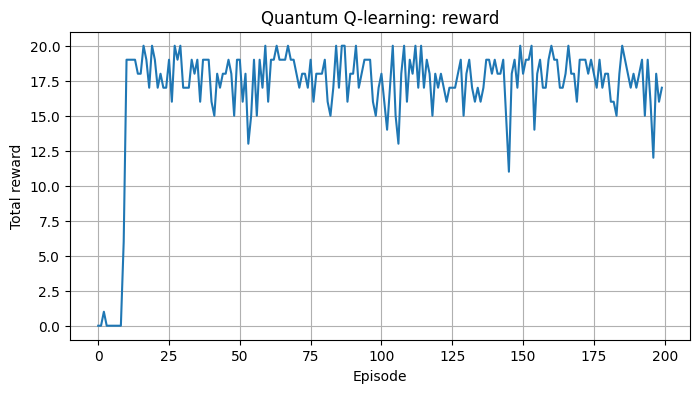

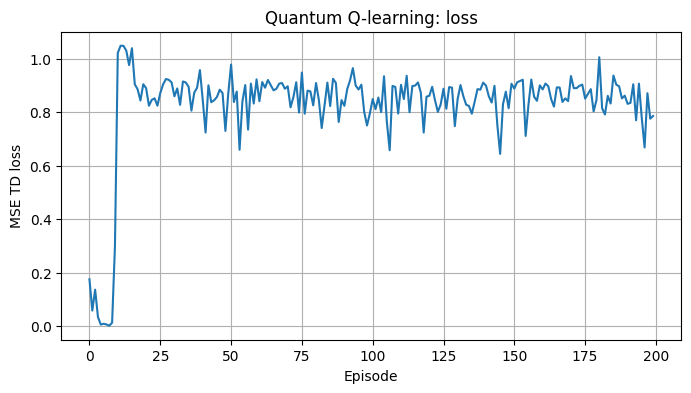

In [8]:
plt.figure(figsize=(8,4))
plt.plot(df["episode"], df["total_reward"])
plt.xlabel("Episode"); plt.ylabel("Total reward"); plt.grid(True); plt.title("Quantum Q-learning: reward"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["episode"], df["loss"])
plt.xlabel("Episode"); plt.ylabel("MSE TD loss"); plt.grid(True); plt.title("Quantum Q-learning: loss"); plt.show()

## 4) Run on IBM Quantum Platform (optional)
Replace the local `Estimator()` with IBM Runtime `EstimatorV2` inside a session.

In [9]:
# from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Session
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# with Session(service=service, backend=backend) as session:
#     estimator_ibm = EstimatorV2(session=session)
#     qnn_ibm = EstimatorQNN(
#         circuit=qc,
#         observables=observable,
#         input_params=list(feature_map.parameters),
#         weight_params=list(ansatz.parameters),
#         estimator=estimator_ibm,
#     )
#     qnn_torch_ibm = TorchConnector(qnn_ibm)
#     # then train similarly (note: hardware noise may require smaller circuits / fewer iters)
print("Optional IBM Runtime cell ready.")

Optional IBM Runtime cell ready.
